# JPG Compression Induced Perturbations

In this notebook, we try to show evidences of jpg compression related perturbations, and we try to show the same behaviour as shown in the paper.

We import librairies

In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import architectures
import cifar10
import utils
import perturbations
import scipy.misc

We retrieve CIFAR Data

In [2]:
X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
y_test = utils.labels_to_categoricals(y_test_lab)

## Perturbation induced on a sample

We show the perturbation induced by jpg compression on a single data

Printing uncompressed array


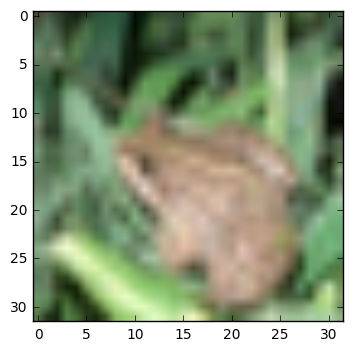

Printing compressed array


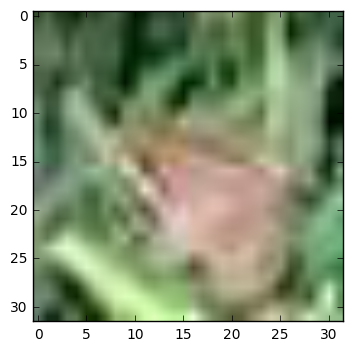

In [3]:
# We take a sample and save it as bad quality jpg
sample = numpy.reshape(X_test[4], [32,32,3])
img = scipy.misc.toimage(sample)
img.save("Images/jpg_compression_test.jpg", "JPEG", quality=50, optimize=True)

# We load back the saved jpg
sample_c = scipy.misc.imread("Images/jpg_compression_test.jpg").astype(numpy.float32)

# We normalize both compressed and uncompressed
sample -= sample.min()
sample /= sample.max()
print("Printing uncompressed array")
plt.imshow(sample)
plt.show()
sample_c -=sample_c.min()
sample_c /= sample_c.max()
print("Printing compressed array")
plt.imshow(sample_c)
plt.show()

We plot the perturbations induced by jpg over each canal

Plotting Red canal Perturbation: Ranging from -0.183709 to 0.215155


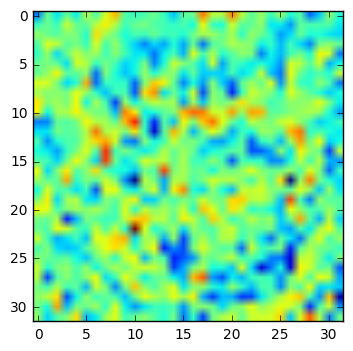

Plotting Green canal Perturbation: Ranging from -0.154169 to 0.140315


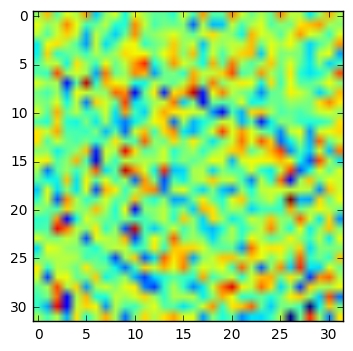

Plotting Blue canal Perturbation: Ranging from -0.163423 to 0.237163


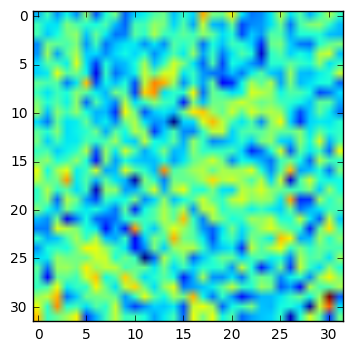

In [4]:
pert=(sample_c-sample)

print("Plotting Red canal Perturbation: Ranging from %f to %f"%(pert[:,:,0].min(),pert[:,:,0].max()))
plt.imshow((sample_c-sample)[:,:,0])
plt.show()
print("Plotting Green canal Perturbation: Ranging from %f to %f"%(pert[:,:,1].min(),pert[:,:,1].max()))
plt.imshow((sample_c-sample)[:,:,1])
plt.show()
print("Plotting Blue canal Perturbation: Ranging from %f to %f"%(pert[:,:,2].min(), pert[:,:,2].max()))
plt.imshow((sample_c-sample)[:,:,2])
plt.show()

## Testing Stability Training Performance over the JPG Compression Induced Perturbations

Now, we compress the whole training set, and we look at precision recall curve for Stability trained networks.

In [5]:
X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
y_test = utils.labels_to_categoricals(y_test_lab)
X_test_c = numpy.ndarray(X_test.shape)
for sample_iter in range(0, X_test.shape[0]):
    sample = numpy.reshape(X_test[sample_iter], [32,32,3])
    img = scipy.misc.toimage(sample)
    img.save("Images/%i.jpg"%sample_iter, "JPEG", quality=50, optimize=True)
    sample_c = scipy.misc.imread("Images/%i.jpg"%sample_iter).astype(numpy.float32)
    X_test_c[sample_iter] = sample_c

We plot compressed and uncompressed samples

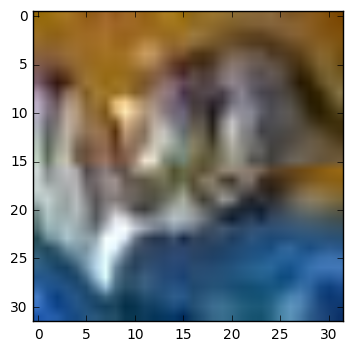

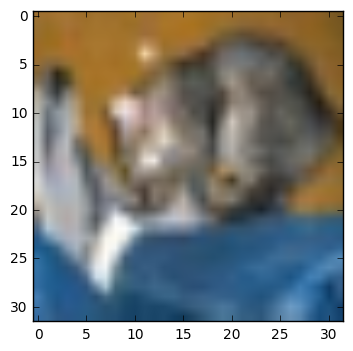

In [6]:
X_test_c = numpy.reshape(X_test_c, [X_test_c.shape[0], -1])
X_test_c = X_test_c.astype(numpy.float32)
X_test_c = X_test_c/255.

X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test.astype(numpy.float32)
X_test = X_test/255.

plt.imshow(numpy.reshape(X_test_c[0],[32,32,3]))
plt.show()
plt.imshow(numpy.reshape(X_test[0],[32,32,3]))
plt.show()

We load the networks

In [10]:
stab_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
stab_net.load('Networks/StabilityTuned1')
class_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
class_net.load('Networks/RegularTuned')

We compute the top-1 accuracies for stabilized and unstabilized network, on compressed and uncompressed data:

In [8]:
class_acc = class_net.test(X_test, y_test)
print("Classicly trained network accuracy uncompressed: %f"%class_acc)
class_acc = class_net.test(X_test_c, y_test)
print("Classicly trained network accuracy compressed: %f"%class_acc)

Classicly trained network accuracy uncompressed: 0.787700
Classicly trained network accuracy compressed: 0.776500


In [11]:
stab_acc = stab_net.test(X_test, y_test)
print("Stability trained network accuracy uncompressed: %f"%stab_acc)
stab_acc = stab_net.test(X_test_c, y_test)
print("Stability trained network accuracy compressed: %f"%stab_acc)

Stability trained network accuracy uncompressed: 0.787900
Stability trained network accuracy compressed: 0.775800


No particular improvement is observed here...

Now, we plot top-n accuracies on perturbed images for networks trained using classic training or stabilized:

CPU times: user 7min 43s, sys: 1min 23s, total: 9min 6s
Wall time: 5min 12s


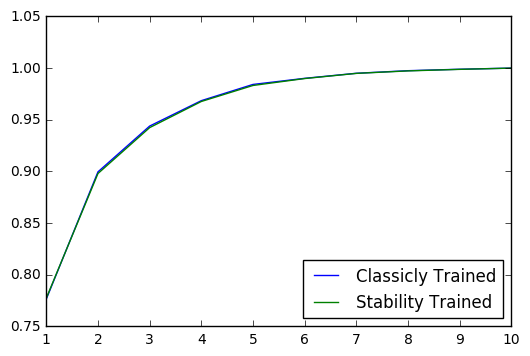

In [9]:
%%time
top_ns = numpy.arange(1,11)
accuracies = numpy.zeros([2, top_ns.shape[0]])

for itr in range(0,top_ns.shape[0]):
    accuracies[0,itr] = class_net.test(X_test_c, y_test, top=top_ns[itr])
    accuracies[1,itr] = stab_net.test(X_test_c, y_test, top=top_ns[itr])
    
plt.plot(top_ns,accuracies[0], label='Classicly Trained')
plt.plot(top_ns,accuracies[1], label='Stability Trained')
plt.legend(loc=4)
plt.savefig('Figures/jpg_top_accuracies.pdf')

Stability shows no different behavior than classic training

## Output distance for stabilized and unstabilized training
We compute the output distance for perturbed and unperturbed images using different _metrics_.

Using the KL-Divergence as distance, we see an improvement for the stabilized network:

In [14]:
out1 = stab_net.evaluate_output(X_test)
out2 = stab_net.evaluate_output(X_test_c)
diff = -out1*numpy.log(out2)
print('KL-Div for stabilized network = %f'%diff.mean())
out1 = class_net.evaluate_output(X_test)
out2 = class_net.evaluate_output(X_test_c)
diff = -out1*numpy.log(out2)
print('KL-Div for regular network = %f'%diff.mean())

KL-Div for stabilized network = 0.043412
KL-Div for regular network = 0.055639


Using Manhattan distance, the stabilized network is farther away than the classic one:

In [15]:
out1 = stab_net.evaluate_output(X_test)
out2 = stab_net.evaluate_output(X_test_c)
diff = numpy.abs(out1-out2).sum()
print('Manhattan distance for stabilized network = %f'%diff.mean())
out1 = class_net.evaluate_output(X_test)
out2 = class_net.evaluate_output(X_test_c)
diff = numpy.abs(out1-out2).sum()
print('Manhattan distance for regular network = %f'%diff.mean())

Manhattan distance for stabilized network = 1397.241455
Manhattan distance for regular network = 1361.273193


Using Euclidean distance, the stabilized network is farther away than the classic one:

In [16]:
out1 = stab_net.evaluate_output(X_test)
out2 = stab_net.evaluate_output(X_test_c)
diff = numpy.sqrt(numpy.power((out1-out2),2).sum())
print('Euclidean distance for stabilized network = %f'%diff.mean())
out1 = class_net.evaluate_output(X_test)
out2 = class_net.evaluate_output(X_test_c)
diff = numpy.sqrt(numpy.power((out1-out2),2).sum())
print('Euclidean distance for regular network = %f'%diff.mean())

Euclidean distance for stabilized network = 16.877075
Euclidean distance for regular network = 14.364313
